<a href="https://colab.research.google.com/github/HyungjoByun/Projects/blob/main/Faster%20RCNN/FasterRCNN_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imgaug --upgrade     #image augmentation을 위해 필요

import torch      #pytorch
import torch.nn as nn     #pytorch network
from torch.utils.data import Dataset, DataLoader      #pytorch dataset
from torch.utils.tensorboard import SummaryWriter     #tensorboard
import torchvision      #torchvision
import torch.optim as optim     #pytorch optimizer
import numpy as np      #numpy
import matplotlib.pyplot as plt     #matplotlib(이미지 표시를 위해 필요)
from collections import OrderedDict     #python라이브러리 (라벨 dictionary를 만들 때 필요)
import os     #os
import xml.etree.ElementTree as Et      #Pascal xml을 읽어올 때 필요
from xml.etree.ElementTree import Element, ElementTree
import cv2      #opencv (box 그리기를 할 때 필요)
from PIL import Image     #PILLOW (이미지 읽기)
import time     #time
import imgaug as ia     #imgaug
from imgaug import augmenters as iaa
from torchvision import transforms      #torchvision transform

#GPU연결
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

# 시작

In [ ]:
if not os.path.isfile("/content/voc_train_val2012_tar"):
  !cp "/content/drive/MyDrive/Faster_RCNN/VOCtrainval_11-May-2012.tar" "/content/voc_train_val2012_tar" 
  ! tar -xf "/content/voc_train_val2012_tar"

In [ ]:
def xml_parser(xml_path):
  xml_path = xml_path


  xml = open(xml_path, "r")
  tree = Et.parse(xml)
  root = tree.getroot()

  size = root.find("size")

  file_name = root.find("filename").text

  object_name = []
  bbox = []

  objects = root.findall("object")
  for _object in objects:
      name = _object.find("name").text
      object_name.append(name)
      bndbox = _object.find("bndbox")
      one_bbox = []
      xmin = bndbox.find("xmin").text
      one_bbox.append(int(float(xmin)))
      ymin = bndbox.find("ymin").text
      one_bbox.append(int(float(ymin)))


      xmax = bndbox.find("xmax").text
      one_bbox.append(int(float(xmax)))
      ymax = bndbox.find("ymax").text
      one_bbox.append(int(float(ymax)))
      

      bbox.append(one_bbox)
  
  return file_name, object_name, bbox


In [ ]:
def makeBox(voc_im,bbox,objects):
  image = voc_im.copy()
  for i in range(len(objects)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
    cv2.putText(image, objects[i], (int(bbox[i][0]), int(bbox[i][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2) # 크기, 색, 굵기
  return image

In [ ]:
xml_list = os.listdir("/content/VOCdevkit/VOC2012/Annotations")
xml_list.sort()

label_set = set()

for i in range(len(xml_list)):
  xml_path = "/content/VOCdevkit/VOC2012/Annotations/"+str(xml_list[i])
  file_name, object_name, bbox = xml_parser(xml_path)
  for name in object_name:
    label_set.add(name)

label_set = sorted(list(label_set))

label_dic = {}
for i, key in enumerate(label_set):
  label_dic[key] = (i+1)
print(label_dic)


{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [ ]:
class Pascal_Voc(Dataset):

  def __init__(self,xml_list,len_data):

    self.xml_list = xml_list
    self.len_data = len_data
    self.to_tensor = transforms.ToTensor()
    self.flip = iaa.Fliplr(0.5)
    self.resize = iaa.Resize({"shorter-side": 600, "longer-side": "keep-aspect-ratio"})

  def __len__(self):
    return self.len_data

  def __getitem__(self, idx):

    xml_path = "/content/VOCdevkit/VOC2012/Annotations/"+str(xml_list[idx])

    file_name, object_name, bbox = xml_parser(xml_path)
    image_path = "/content/VOCdevkit/VOC2012/JPEGImages/"+str(file_name)
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    image, bbox = self.flip(image = image, bounding_boxes = np.array([bbox]))
    image, bbox = self.resize(image = image,bounding_boxes = bbox)
    bbox = bbox.squeeze(0).tolist()
    image = self.to_tensor(image)

    targets = []
    d = {}
    d['boxes'] = torch.tensor(bbox,device=device)
    d['labels'] = torch.tensor([label_dic[x] for x in object_name],dtype=torch.int64,device = device)
    targets.append(d)

    return image, targets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[[244,  34, 555, 528],
         [  3, 277, 479, 600]]], device='cuda:0'), 'labels': tensor([[15, 14]], device='cuda:0')}]


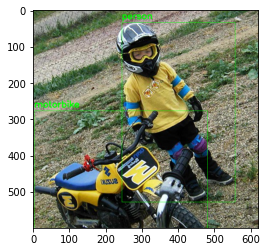

In [ ]:
#데이터 테스트 출력
dataset = Pascal_Voc(xml_list,100)
dataloader = DataLoader(dataset,shuffle=True)

for i, (image, targets) in enumerate(dataloader):
  test_image = image
  test_target = targets
  if i == 0 : break

print(test_target)

labels = test_target[0]['labels'].squeeze_(0)
objects = []
for lb in labels:
  objects.append([k for k, v in label_dic.items() if v == lb][0])

plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(),test_target[0]['boxes'].squeeze(0),objects)
plt.imshow(plot_image)

In [ ]:
backbone = torchvision.models.vgg16(pretrained=True).features[:-1]
backbone_out = 512
backbone.out_channels = backbone_out

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))

resolution = 7
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,21) #21개 class

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 600, max_size = 1000,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,
                   rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,
                   rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.05, box_nms_thresh=0.7,box_detections_per_img=300,
                   box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 )
#roi head 있으면 num_class = None으로 함

for param in model.rpn.parameters():
  torch.nn.init.normal_(param,mean = 0.0, std=0.01)

for name, param in model.roi_heads.named_parameters():
  if "bbox_pred" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.001)
  elif "weight" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.01)
  if "bias" in name:
    torch.nn.init.zeros_(param)

In [ ]:
from torchsummary import summary
summary(backbone,(3,600,1000),device = 'cpu')
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 600, 1000]           1,792
              ReLU-2        [-1, 64, 600, 1000]               0
            Conv2d-3        [-1, 64, 600, 1000]          36,928
              ReLU-4        [-1, 64, 600, 1000]               0
         MaxPool2d-5         [-1, 64, 300, 500]               0
            Conv2d-6        [-1, 128, 300, 500]          73,856
              ReLU-7        [-1, 128, 300, 500]               0
            Conv2d-8        [-1, 128, 300, 500]         147,584
              ReLU-9        [-1, 128, 300, 500]               0
        MaxPool2d-10        [-1, 128, 150, 250]               0
           Conv2d-11        [-1, 256, 150, 250]         295,168
             ReLU-12        [-1, 256, 150, 250]               0
           Conv2d-13        [-1, 256, 150, 250]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
writer = SummaryWriter("/content/drive/MyDrive/Faster_RCNN/runs/Faster_RCNN")
%load_ext tensorboard
%tensorboard --logdir="/content/drive/MyDrive/Faster_RCNN/runs"

In [ ]:
def Total_Loss(loss):
  loss_objectness = loss['loss_objectness']
  loss_rpn_box_reg = loss['loss_rpn_box_reg']
  loss_classifier = loss['loss_classifier']
  loss_box_reg = loss['loss_box_reg']

  rpn_total = loss_objectness + 10*loss_rpn_box_reg
  fast_rcnn_total = loss_classifier + 1*loss_box_reg

  total_loss = rpn_total + fast_rcnn_total

  return total_loss

In [ ]:
total_epoch = 70

len_data = 15000
term = 1000

loss_sum = 0

model.to(device)

optimizer = torch.optim.SGD(params = model.parameters(),lr = 0.001, momentum = 0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,total_epoch,eta_min=0.00001)

try:
  check_point = torch.load("/content/drive/My Drive/Faster_RCNN/Check_point.pth") 
  start_epoch = check_point['epoch']
  start_idx = check_point['iter']
  model.load_state_dict(check_point['state_dict'])
  optimizer.load_state_dict(check_point['optimizer'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,total_epoch,eta_min=0.00001,last_epoch = start_epoch)
  scheduler.load_state_dict(check_point['scheduler'])

  if start_idx == len_data: 
    start_idx = 0
    start_epoch = start_epoch + 1

except:
  print("check point load error!")
  start_epoch = 0
  start_idx = 0

print("start_epoch = {} , start_idx = {}".format(start_epoch,start_idx))

print("Training Start")
model.train()
start = time.time()

for epoch in range(start_epoch,total_epoch):
  
  writer.add_scalar('Learning Rate',scheduler.get_last_lr()[0], epoch)

  dataset = Pascal_Voc(xml_list[:len_data],len_data - start_idx)
  dataloader = DataLoader(dataset,shuffle=True)

  for i, (image,targets)in enumerate(dataloader,start_idx):

    optimizer.zero_grad()

    targets[0]['boxes'].squeeze_(0)
    targets[0]['labels'].squeeze_(0)
    
    loss = model(image.to(device),targets)
    total_loss = Total_Loss(loss)
    loss_sum += total_loss

    if (i+1) % term == 0:
      end = time.time()
      print("Epoch {} | Iter {} | Loss: {} | Duration: {} min".format(epoch,(i+1),(loss_sum/term).item(),int((end-start)/60)))
      writer.add_scalar('Training Loss',loss_sum / term, epoch * len_data + i)
      
      state = {
        'epoch': epoch,
        'iter' : i+1,
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
      }
      torch.save(state,"/content/drive/My Drive/Faster_RCNN/Check_point.pth")
     
      loss_sum = 0
      start = time.time()
    
    total_loss.backward()
    optimizer.step()

  start_idx = 0
  scheduler.step() 

  state = {
      'epoch': epoch,
      'iter' : i+1,
      'state_dict': model.state_dict(),
      'optimizer' : optimizer.state_dict(),
      'scheduler': scheduler.state_dict()
    }
  torch.save(state,"/content/drive/My Drive/Faster_RCNN/Check_point.pth")

  if (epoch+1) % 10 == 0: 
    torch.save(model.state_dict(),"/content/drive/My Drive/Faster_RCNN/Epoch{}.pth".format(epoch))
 